In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from model.aotgan import InpaintGenerator

import utils

import torch
import os
import pandas as pd 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import cv2
import numpy as np 


In [2]:
ts_img_dir = '/mnt/HDD/octc/mask_abstract/test'
ts_mask_dir = '/mnt/HDD/octc/mask_abstract/mask'

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(
    image_dir = ts_img_dir,
    mask_dir = ts_mask_dir,
    transform= test_transform,
    mask_transform= test_transform,
    testing = True,
    mask_shuffle = False,
)
ts_batch = 16
test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = False)


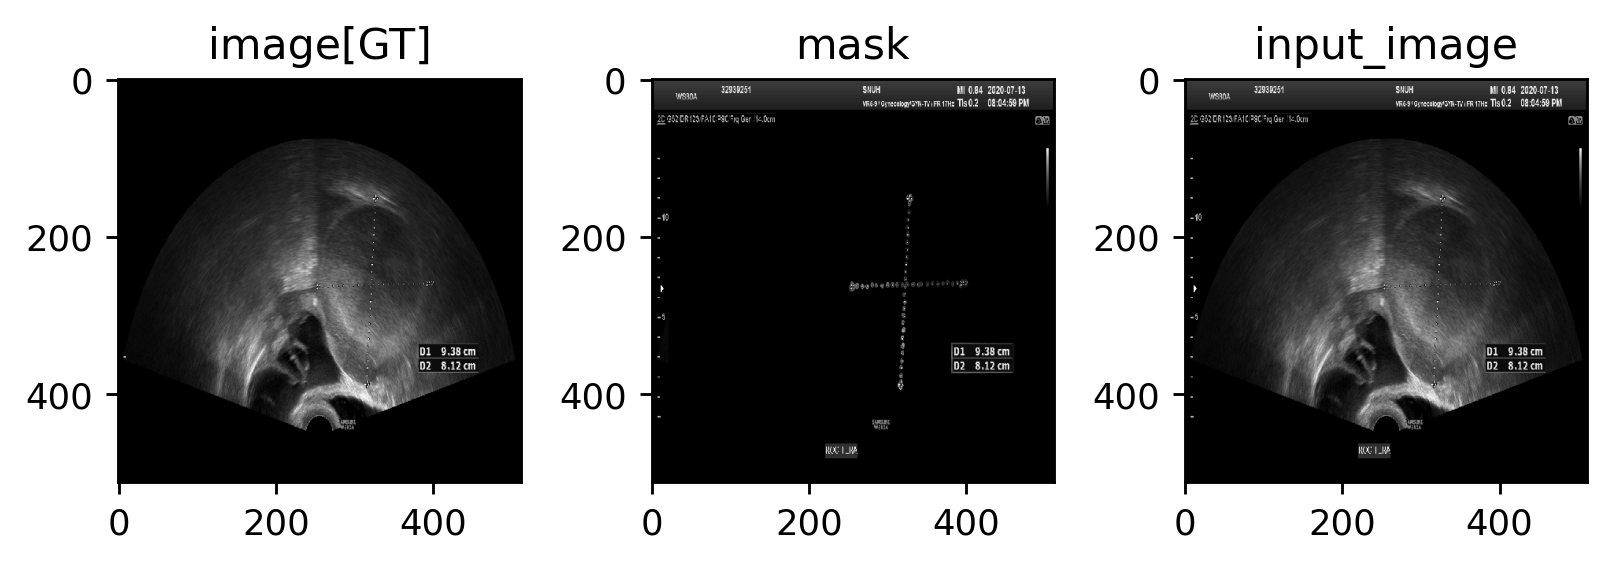

In [3]:
def plotting(images, masks, input_images):
    plt.figure(dpi =256)
    plt.subplot(131)
    plt.imshow(images[1,0], cmap= 'gray')
    plt.title('image[GT]')
    plt.subplot(132)
    plt.imshow(masks[1,0 ], cmap= 'gray')
    plt.title('mask')
    plt.subplot(133)
    plt.imshow(input_images[1,0 ], cmap= 'gray')
    plt.title('input_image')
    plt.tight_layout()
    plt.show()

for images, masks, paths in test_loader:
    # mask가 0이 아닌 부분에 대해 image를 mask로 대체
    input_images = images.clone()
    # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
    input_images[masks != 0] = masks[masks != 0] 
        
    # input_images 처리해줫으니 다시 masks를 1채널로 변경
    masks = masks[:,0,:,:].unsqueeze(1)
    plotting(images, masks, input_images)
    break


In [5]:
from model import VAE

input_dim = 4
hidden_dim =512
latent_dim = 32
n_embeddings = 512
output_dim = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = VAE.Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VAE.VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = VAE.Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = VAE.Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)

load_path = '/mnt/HDD/oci_models/models/VAE_v1_240510/model_27.pt'
save_path = '/mnt/HDD/oci_models/models/VAE_v1_240510/result_ext'
visual_save_path = '/mnt/HDD/oci_models/models/VAE_v1_240510/visual_ext'
os.makedirs(save_path, exist_ok= True)
os.makedirs(visual_save_path, exist_ok= True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
G_check = torch.load(load_path)['netG_state_dict']
model.load_state_dict(G_check)

torch.load(load_path).keys()

dict_keys(['epoch', 'netG_state_dict', 'optimG_state_dict'])

In [10]:
weight = torch.load('/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/AI/inference/model/weight/vae.pt')
weight

{'epoch': 27,
 'netG_state_dict': OrderedDict([('encoder.strided_conv_1.weight',
               tensor([[[[ 0.0835, -0.0138,  0.0018, -0.0477],
                         [-0.0358,  0.1073,  0.0951, -0.0404],
                         [ 0.0714, -0.0231,  0.1201, -0.0651],
                         [-0.0577, -0.0549, -0.0984,  0.1520]],
               
                        [[ 0.0229, -0.0828,  0.1006,  0.1115],
                         [-0.0221, -0.1117,  0.0561,  0.0455],
                         [ 0.0284,  0.0158, -0.0687, -0.0367],
                         [-0.0182, -0.0043, -0.0879,  0.0768]],
               
                        [[ 0.0031, -0.1112,  0.0973, -0.0929],
                         [-0.0252,  0.0834, -0.0665, -0.0739],
                         [ 0.0535, -0.0456, -0.0856, -0.0636],
                         [-0.0567,  0.0160,  0.1363,  0.0083]],
               
                        [[ 0.0613, -0.0094,  0.0762, -0.0320],
                         [-0.1444,  0.0408, -0.01

In [6]:
from utils.metric import calculate_and_log_metrics, compare_fid
metric = {
    'mae' : 0,
    'mse' : 0, 
    'psnr' : 0,
    'ssim' : 0,
    'fid' : 0
}

2024-05-14 02:30:44.762626: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 02:30:44.763701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 02:30:44.784626: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 02:30:45.176255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
mae_sum, mse_sum, psnr_sum, ssim_sum = 0, 0, 0, 0
total_samples = len(test_loader.dataset)

with torch.no_grad():

    model.eval()
    for images, masks, image_paths in test_loader:
        images, masks = images.to(device), masks.to(device)
        ### 전처리
        # mask가 0이 아닌 부분에 대해 image를 mask로 대체
        input_images = images.clone()
        # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
        input_images[masks != 0] = masks[masks != 0] 
        # input_images 처리해줫으니 다시 masks를 1채널로 변경
        masks = masks[:,0,:,:].unsqueeze(1)
        # 입력이미지 device 할당
        input_images = input_images.to(device) 

        ### inference
        pred_images, commitment_loss, codebook_loss, perplexity = model(input_images, masks)
        
        ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
        masks = masks.repeat(1,3,1,1)
        comp_images = images.clone()
        comp_images[masks != 0] = pred_images[masks != 0]
        masks = masks[:,0,:,:].unsqueeze(1)
        
        # metric를 평가하기 위해 metric_images와 pred_images에서 mask와 같은 인덱스인 부분을 제외하고 0으로 만들기 
        metric_gt, metric_pred = images.clone(), pred_images.clone()
        metric_gt[masks.repeat(1,3,1,1) == 0] = 0
        metric_pred[masks.repeat(1,3,1,1) == 0] = 0
        
        # metric 계산 : mask인 부분만 계산! 
        for i in range(images.size(0)):
            mae, mse, psnr, ssim = calculate_and_log_metrics(metric_gt[i,0].cpu().detach().numpy(), metric_pred[i,0].cpu().detach().numpy())
            mae_sum += mae 
            mse_sum += mse 
            psnr_sum += psnr
            ssim_sum += ssim
        fid = compare_fid(metric_gt, metric_pred) 
        
        metric['mae'] += mae_sum / total_samples
        metric['mse'] += mse_sum / total_samples
        metric['psnr'] += psnr_sum / total_samples
        metric['ssim'] += ssim_sum / total_samples
        metric['fid'] += fid / len(test_loader)

        #img_save
        for input_image, mask, pred_image, path in zip(input_images, masks, comp_images, image_paths):
            file_name = path.split('/')[-1]
            # Origianl Image 대로 Resize
            original_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            utils.test_plotting(input_image, mask, pred_image, save_path = os.path.join(visual_save_path, file_name))

            pred_image = pred_image.cpu().detach().numpy()
            # Transpose pred_image from (C, H, W) to (H, W, C) for OpenCV compatibility
            pred_image = np.transpose(pred_image, (1, 2, 0))
            # Now, resize pred_image to match the original image's dimensions
            pred_image = cv2.resize(pred_image, (original_image.shape[1], original_image.shape[0]))  # Note the order of shape
            pred_image = np.clip(pred_image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
            cv2.imwrite(os.path.join(save_path, file_name), pred_image)
# metric save 
df = pd.DataFrame([metric])
df.to_csv(os.path.join(visual_save_path, 'metric.csv'), index = False)

NameError: name 'test_loader' is not defined

# Application External Data Check

1647

206